Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
%pwd

'/content'

In [6]:
os.chdir('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/')

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Train")
data_dir_test = pathlib.Path('./Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,image_size=(img_height,img_width))

Found 6928 files belonging to 9 classes.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,seed=123,image_size=(img_height,img_width))

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

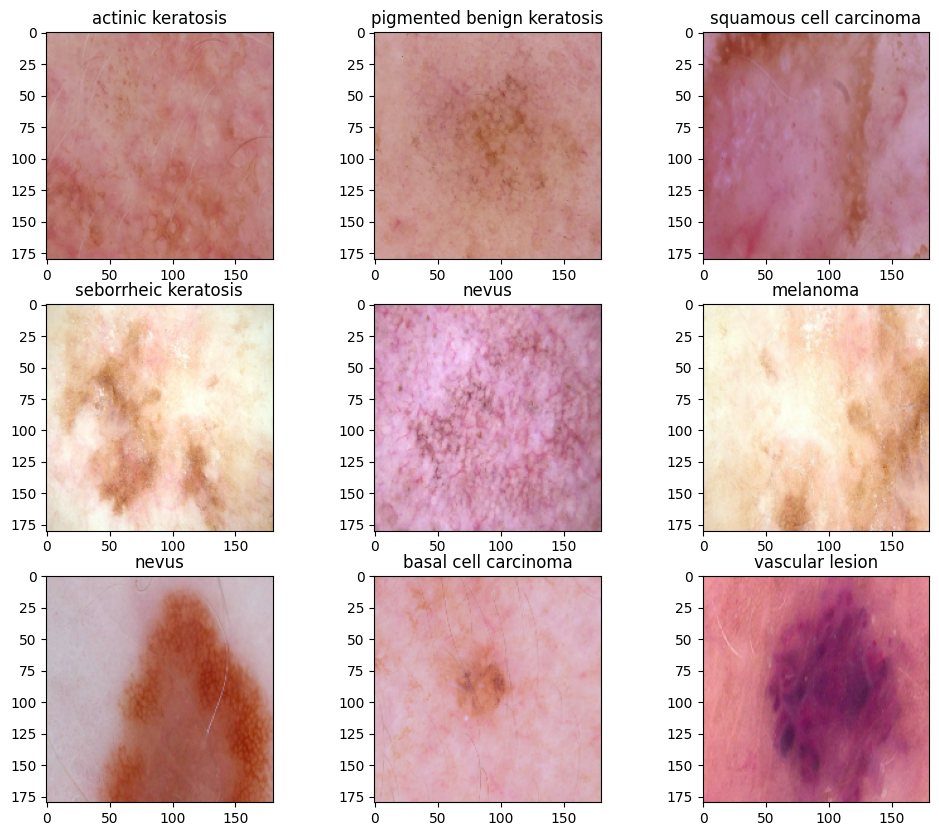

In [13]:
import matplotlib.pyplot as plt
import os

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,10))
for img,label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
model = keras.Sequential([
    layers.InputLayer(input_shape=(180,180,3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),



    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 2527s 428ms/step - accuracy: 0.1825 - loss: 2.2107 - val_accuracy: 0.3051 - val_loss: 2.0560
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.3843 - loss: 1.6073 - val_accuracy: 0.3305 - val_loss: 2.0993
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4450 - loss: 1.4677 - val_accuracy: 0.3475 - val_loss: 2.0340
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.4861 - loss: 1.3494 - val_accuracy: 0.3390 - val_loss: 2.2157
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5218 - loss: 1.2739 - val_accuracy: 0.3559 - val_loss: 2.1271
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5557 - loss: 1.2024 - val_accuracy: 0.3898 - val_loss: 2.5992
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5722 - loss: 1.1526 - val_accuracy: 0.3729 - val_loss: 2.5440
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5918 - loss: 1.0732 - 

### Visualizing training results

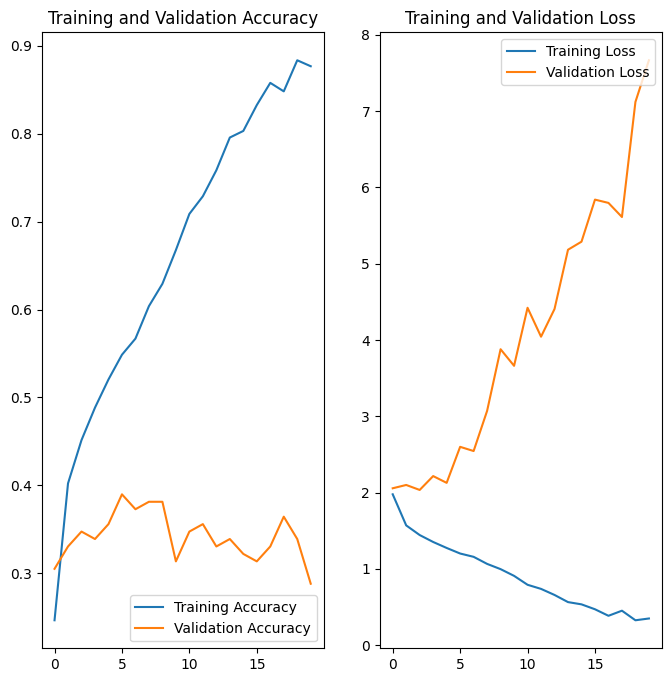

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

We can observe that the model accuracy on the training data is increasing but validation accuracy is not increasing to that level. This has also been proved by the loss as the training loss is decreasing quite well but the validation loss is increasing.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

# we will try to introduce some variations of the images like rotating the images to some degree
# flipping the image horizontally or vertically etc.
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4),
    layers.RandomContrast(0.3)
])

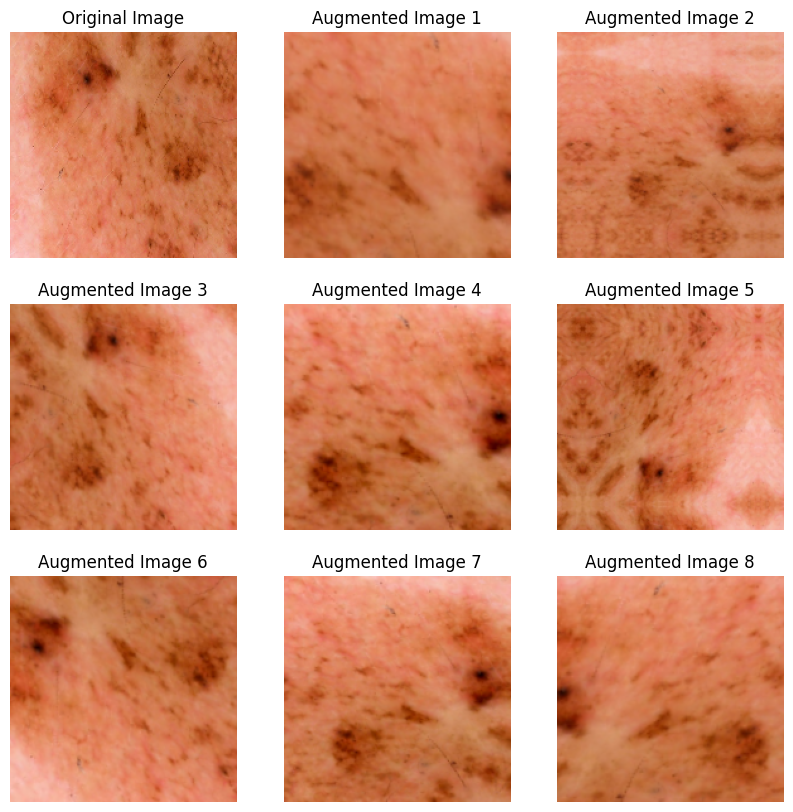

In [21]:
# # Todo, visualize how your augmentation strategy works for one instance of training image.

# Extract one batch from the dataset
for images, labels in train_dataset.take(1):
    image = images[0]

# Plot the original image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(image.numpy())
plt.title('Original Image')
plt.axis('off')

# Apply data augmentation multiple times and plot the results
for i in range(8):
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.subplot(3, 3, i+2)
    plt.imshow(augmented_image[0].numpy())
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')

plt.show()

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
model = keras.Sequential([

    layers.InputLayer(input_shape=(180,180,3)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])



### Compiling the model

In [23]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.1386 - loss: 2.1877 - val_accuracy: 0.1356 - val_loss: 3.9516
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.1284 - loss: 2.1844 - val_accuracy: 0.1356 - val_loss: 3.4707
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.1301 - loss: 2.1854 - val_accuracy: 0.1356 - val_loss: 3.3930
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.1364 - loss: 2.1803 - val_accuracy: 0.1356 - val_loss: 3.2698
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.1413 - loss: 2.1819 - val_accuracy: 0.1356 - val_loss: 3.3364
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.1377 - loss: 2.1804 - val_accuracy: 0.1356 - val_loss: 3.3118
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.1377 - loss: 2.1800 - val_accuracy: 0.1356 - val_loss: 3.3489
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.1385 - loss: 2.1799 - 

### Visualizing the results

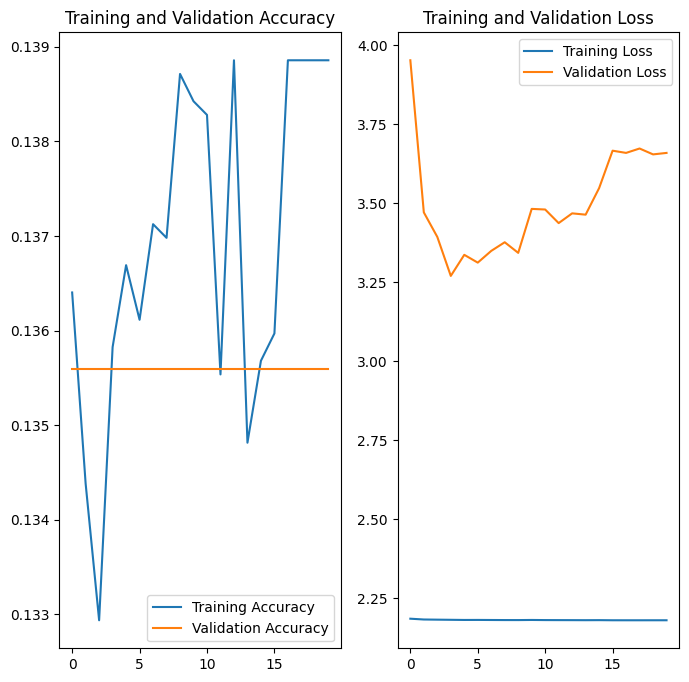

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We see that the dropout layer is also not helping and the model is performing really poorly. Lets do data augmentation to generate more data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class pigmented benign keratosis: 463 images
Class basal cell carcinoma: 377 images
Class squamous cell carcinoma: 182 images
Class melanoma: 439 images
Class seborrheic keratosis: 78 images
Class vascular lesion: 140 images
Class actinic keratosis: 115 images
Class dermatofibroma: 96 images
Class nevus: 358 images


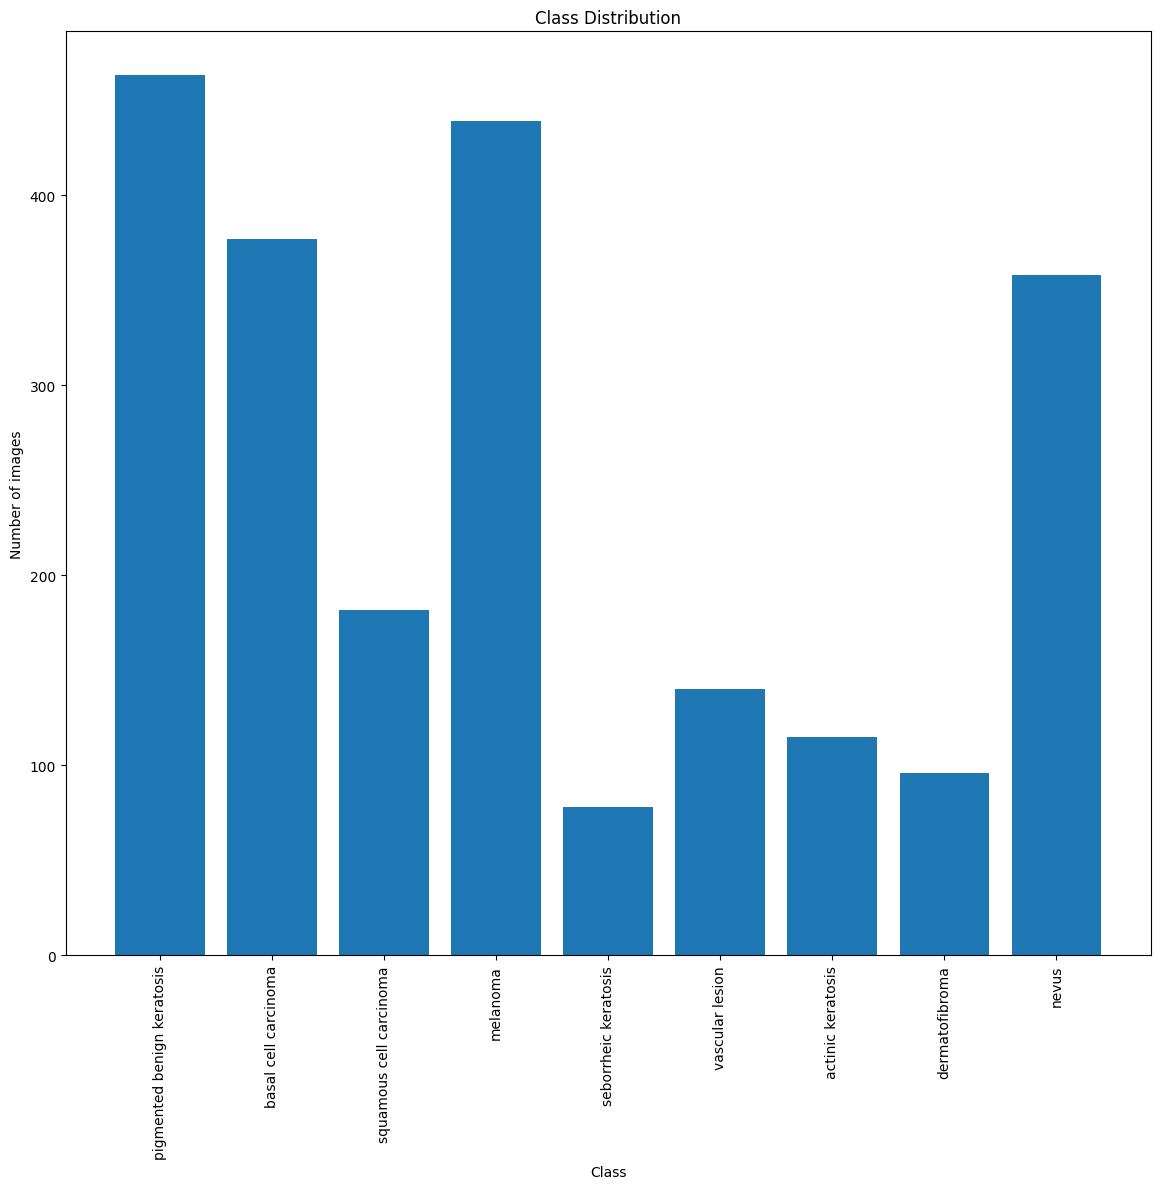

In [26]:
## Your code goes here.


classes = os.listdir(data_dir_train)


class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir_train, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

for cls, count in class_counts.items():
    print(f'Class {cls}: {count} images')

plt.figure(figsize=(14, 12))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### -- seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### -- Melanoma, Nevus Basal cell carcinoma and Pigmented benign keratosis dominate the data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=r'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    # Rotate the images
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Flip the images horizontally
    p.flip_left_right(probability=0.5)

    # Zoom into the images randomly
    p.zoom_random(probability=0.5, percentage_area=0.8)

    # Shear the images
    p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)

    # Apply random distortion
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

    # Center zooming
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4689


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
import glob
# path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list
path_list = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))

print(path_list)

['Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024981.jpg_f470d783-67fd-4fc4-9d32-4220a46e559a.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025297.jpg_eb15b018-c076-4014-9e1a-05ce543b1749.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024910.jpg_0f2d0cab-adce-4e1e-b955-bd37647e16cf.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024581.jpg_dfeddd90-a43d-4930-8a3b-1ce403f60b9a.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025526.jpg_84943d35-e26a-4e75-8d5a-6ef267d0c9dc.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025366.jpg_9b3a96ac-944f-4462-a7df-f36b6f77f8a2.jpg', 'Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028264.jpg_781dc13f-1ed5-4861-87f2-1c18ceb0a57e.jpg', 'Train/pigmented benign keratosis/output

In [31]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

image_paths = glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))


lesion_list_new = list(set(os.path.basename(os.path.dirname(os.path.dirname(y))) for y in image_paths))


print(lesion_list_new)

['dermatofibroma', 'melanoma', 'basal cell carcinoma', 'pigmented benign keratosis', 'vascular lesion', 'squamous cell carcinoma', 'seborrheic keratosis', 'actinic keratosis', 'nevus']


In [32]:
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print(df2)
# new_df = original_df.append(df2)

                                                Path  \
0  Train/pigmented benign keratosis/output/pigmen...   
1  Train/pigmented benign keratosis/output/pigmen...   
2  Train/pigmented benign keratosis/output/pigmen...   
3  Train/pigmented benign keratosis/output/pigmen...   
4  Train/pigmented benign keratosis/output/pigmen...   
5  Train/pigmented benign keratosis/output/pigmen...   
6  Train/pigmented benign keratosis/output/pigmen...   
7  Train/pigmented benign keratosis/output/pigmen...   
8  Train/pigmented benign keratosis/output/pigmen...   

                        Label  
0              dermatofibroma  
1                    melanoma  
2        basal cell carcinoma  
3  pigmented benign keratosis  
4             vascular lesion  
5     squamous cell carcinoma  
6        seborrheic keratosis  
7           actinic keratosis  
8                       nevus  


In [34]:
df2['Label'].value_counts()

Label
dermatofibroma                1
melanoma                      1
basal cell carcinoma          1
pigmented benign keratosis    1
vascular lesion               1
squamous cell carcinoma       1
seborrheic keratosis          1
actinic keratosis             1
nevus                         1
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
path_to_training_dataset

'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

In [37]:
data_dir_train=path_to_training_dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6928 files belonging to 9 classes.
Using 5543 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6928 files belonging to 9 classes.
Using 1385 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [75]:
## your code goes here

model = keras.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [76]:
## your code goes here
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [77]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.1793 - loss: 2.9369 - val_accuracy: 0.3458 - val_loss: 1.8584
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.3449 - loss: 1.8359 - val_accuracy: 0.4224 - val_loss: 1.6511
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.4397 - loss: 1.5527 - val_accuracy: 0.4318 - val_loss: 1.5371
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.4929 - loss: 1.3768 - val_accuracy: 0.4310 - val_loss: 1.6076
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.5345 - loss: 1.2860 - val_accuracy: 0.4693 - val_loss: 1.4200
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 80s 232ms/step - accuracy: 0.6009 - loss: 1.1176 - val_accuracy: 0.4534 - val_loss: 1.5452
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - accuracy: 0.6346 - loss: 1.0136 - val_accuracy: 0.4816 - val_loss: 1.4937
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.7152 - loss: 0

In [78]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

Found 118 files belonging to 9 classes.


In [79]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3189 - loss: 7.9124
Test accuracy: 0.2711864411830902


#### **Todo:**  Visualize the model results

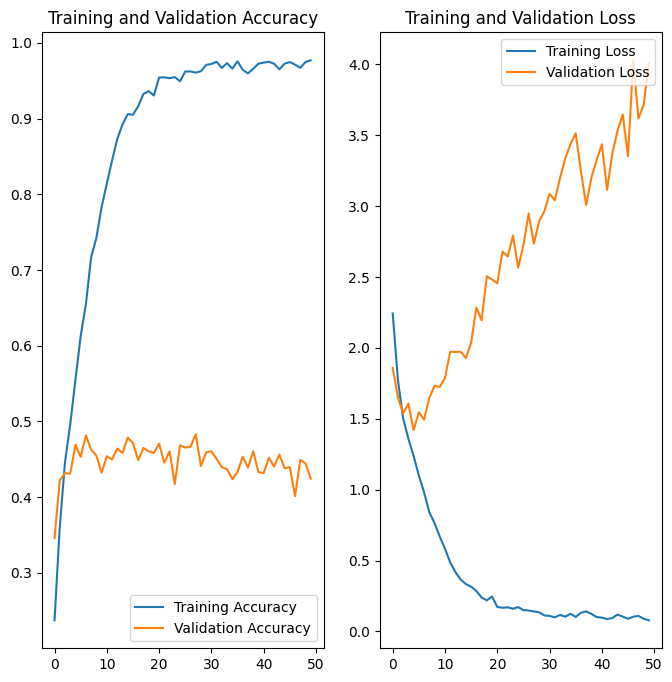

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes the class rebalance helped to certain extend but needs more improvement.